In [5]:
import sys
import polars as pl
import geopolars as gpl
import geopandas as gpd
from pathlib import Path

In [6]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
from urban_tools.arc_tools import h3_to_polygon

# Path to the saved JSON file
file_path = f"{os.environ['HOME']}/CQR_Experiments/Training_on_one_city_predicting_on_another_NGB.json"

# Open the JSON file and load the data into a Python dictionary
with open(file_path, "r") as file:
    predictions_dict = json.load(file)

## Clustering


In [8]:
def create_cmap(n_clusters):
    cmap = plt.cm.get_cmap("Set1", n_clusters)
    colors = [cmap(i) for i in range(cmap.N)]
    color_map = dict(zip(range(cmap.N), colors))
    return cmap


def create_contextily_plt(df, ax, cmap, cluster_col="cluster") -> plt.Axes:
    import geopandas as gpd
    import contextily as ctx
    from shapely.geometry import Polygon
    import h3

    plot_df = df.copy()
    plot_df["geometry"] = df.index.map(h3_to_polygon)
    warszawa_df = gpd.GeoDataFrame(plot_df, crs="EPSG:4326")

    warszawa_df.to_crs(epsg=3857).plot(
        ax=ax,
        alpha=0.6,
        legend=True,
        column=plot_df[cluster_col].astype(str),
        cmap=cmap,
    )
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    return ax


def summarize_clusters(
    service_df, log_service_col: str, cluster_col: str = "cluster"
) -> pd.DataFrame:
    # summarize the service time by cluster
    cluster_service_time = service_df.groupby(cluster_col)[log_service_col].agg(
        ["mean", "median", "std", "count"]
    )
    cluster_service_time.columns = [
        "mean_service_time",
        "median_service_time",
        "std_service_time",
        "count",
    ]
    cluster_service_time[
        ["mean_service_time", "median_service_time"]
    ] = cluster_service_time[["mean_service_time", "median_service_time"]]

    # group by hexagon and summarize the number of deliveries
    cluster_hex_service_time = service_df.groupby("h3").agg(
        {log_service_col: ["mean", "count"], cluster_col: "first"}
    )
    cluster_hex_service_time.columns = ["mean_service_time", "count", "cluster"]
    cluster_hex_service_time["mean_service_time"] = cluster_hex_service_time[
        "mean_service_time"
    ]

    # group by cluster
    cluster_hex_service_time = cluster_hex_service_time.groupby("cluster").agg(
        {"mean_service_time": "mean", "count": "count"}
    )

    cluster_hex_service_time.columns = ["mean_service_time_hex", "count_hex"]
    cluster_hex_service_time["mean_service_time_hex"] = cluster_hex_service_time[
        "mean_service_time_hex"
    ]
    return cluster_service_time.merge(
        cluster_hex_service_time, left_index=True, right_index=True
    )


def label_deliveries(delivery_df, label_df, col_name="cluster", copy=True):
    delivery_df = delivery_df.copy() if copy else delivery_df
    delivery_df[col_name] = label_df.loc[delivery_df["region_id"]][col_name].values
    return delivery_df


def create_dist_plt(
    labelled_deliveries, service_col, ax, cmap, summary_df=None, cluster_col="cluster"
) -> plt.Axes:
    if summary_df is None:
        summary_df = summarize_clusters(labelled_deliveries, service_col + "_log")

    sns.histplot(
        data=labelled_deliveries,
        x=service_col,
        hue=cluster_col,
        stat="density",
        legend=True,
        ax=ax,
        palette=cmap,
    )

    sns.kdeplot(
        data=labelled_deliveries,
        x=service_col,
        hue=cluster_col,
        ax=ax,
        alpha=1,
        palette=cmap,
        legend=False,
        # make the line thicker
        linewidth=2,
    )

    # add a vertical line for the means of the

    for label in ax.get_legend().get_texts():
        label_int = int(label.get_text())
        label.set_text(
            f"Cluster {label_int}, Median: {round(summary_df.loc[label_int, 'median_service_time'], 2)}s, N: {summary_df.loc[label_int, 'count']}"
        )

### Get embeddings Dataframe


In [9]:
# add the
ROOT = os.path.join(Path(os.getcwd()), "cargo-bike-analysis")
sys.path.append(str(ROOT))
from src.config import CargoBikeConfig, load_config


config = load_config(ROOT + "/config" + "/paper.yaml")

h3_df = pd.concat(
    [gpd.read_parquet(city.h3_file).assign(city=city.name) for city in config.Cities],
    axis=0,
).query("is_city")


## Load the Service Time Data

delivery_df = pl.concat(
    [
        pl.read_parquet(city.file).select(
            ["h3", pl.col(city.service_time_col).alias("service_time")]
        )
        for city in config.ServiceTime
    ],
)

# this does two things, one adds the city label and 2, it crops to the city limits
service_time_df = delivery_df.join(
    pl.DataFrame(h3_df.reset_index()[["region_id", "city"]]),
    left_on="h3",
    right_on="region_id",
    how="inner",
).with_columns(
    [
        pl.col("service_time").log().alias("service_time_log"),
    ]
)


service_time_df = service_time_df.with_columns(pl.count().over("h3").alias("h3_count"))

embedding_df = pl.read_parquet(config.GeoVex.embedding_file)

embedding_df = embedding_df.join(
    service_time_df, left_on="region_id", right_on="h3", how="inner"
)
embedding_df = pd.DataFrame(embedding_df, columns=embedding_df.columns)


def get_del_df(city):
    city_df = embedding_df[embedding_df["city"].str.contains(city)]
    return city_df[city_df["h3_count"] >= 1]

In [10]:
from sklearn.model_selection import train_test_split, KFold
from mapie.regression import MapieRegressor
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner, default_linear_learner
from ngboost.scores import CRPS, MLE
from ngboost.distns import LogNormal, Normal
from sklearn.cluster import AgglomerativeClustering
from scipy import stats

/tmp/ipykernel_1455481/2500515327.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', n_clusters)


========================================Studying Boston, USA========================================


KeyboardInterrupt: 

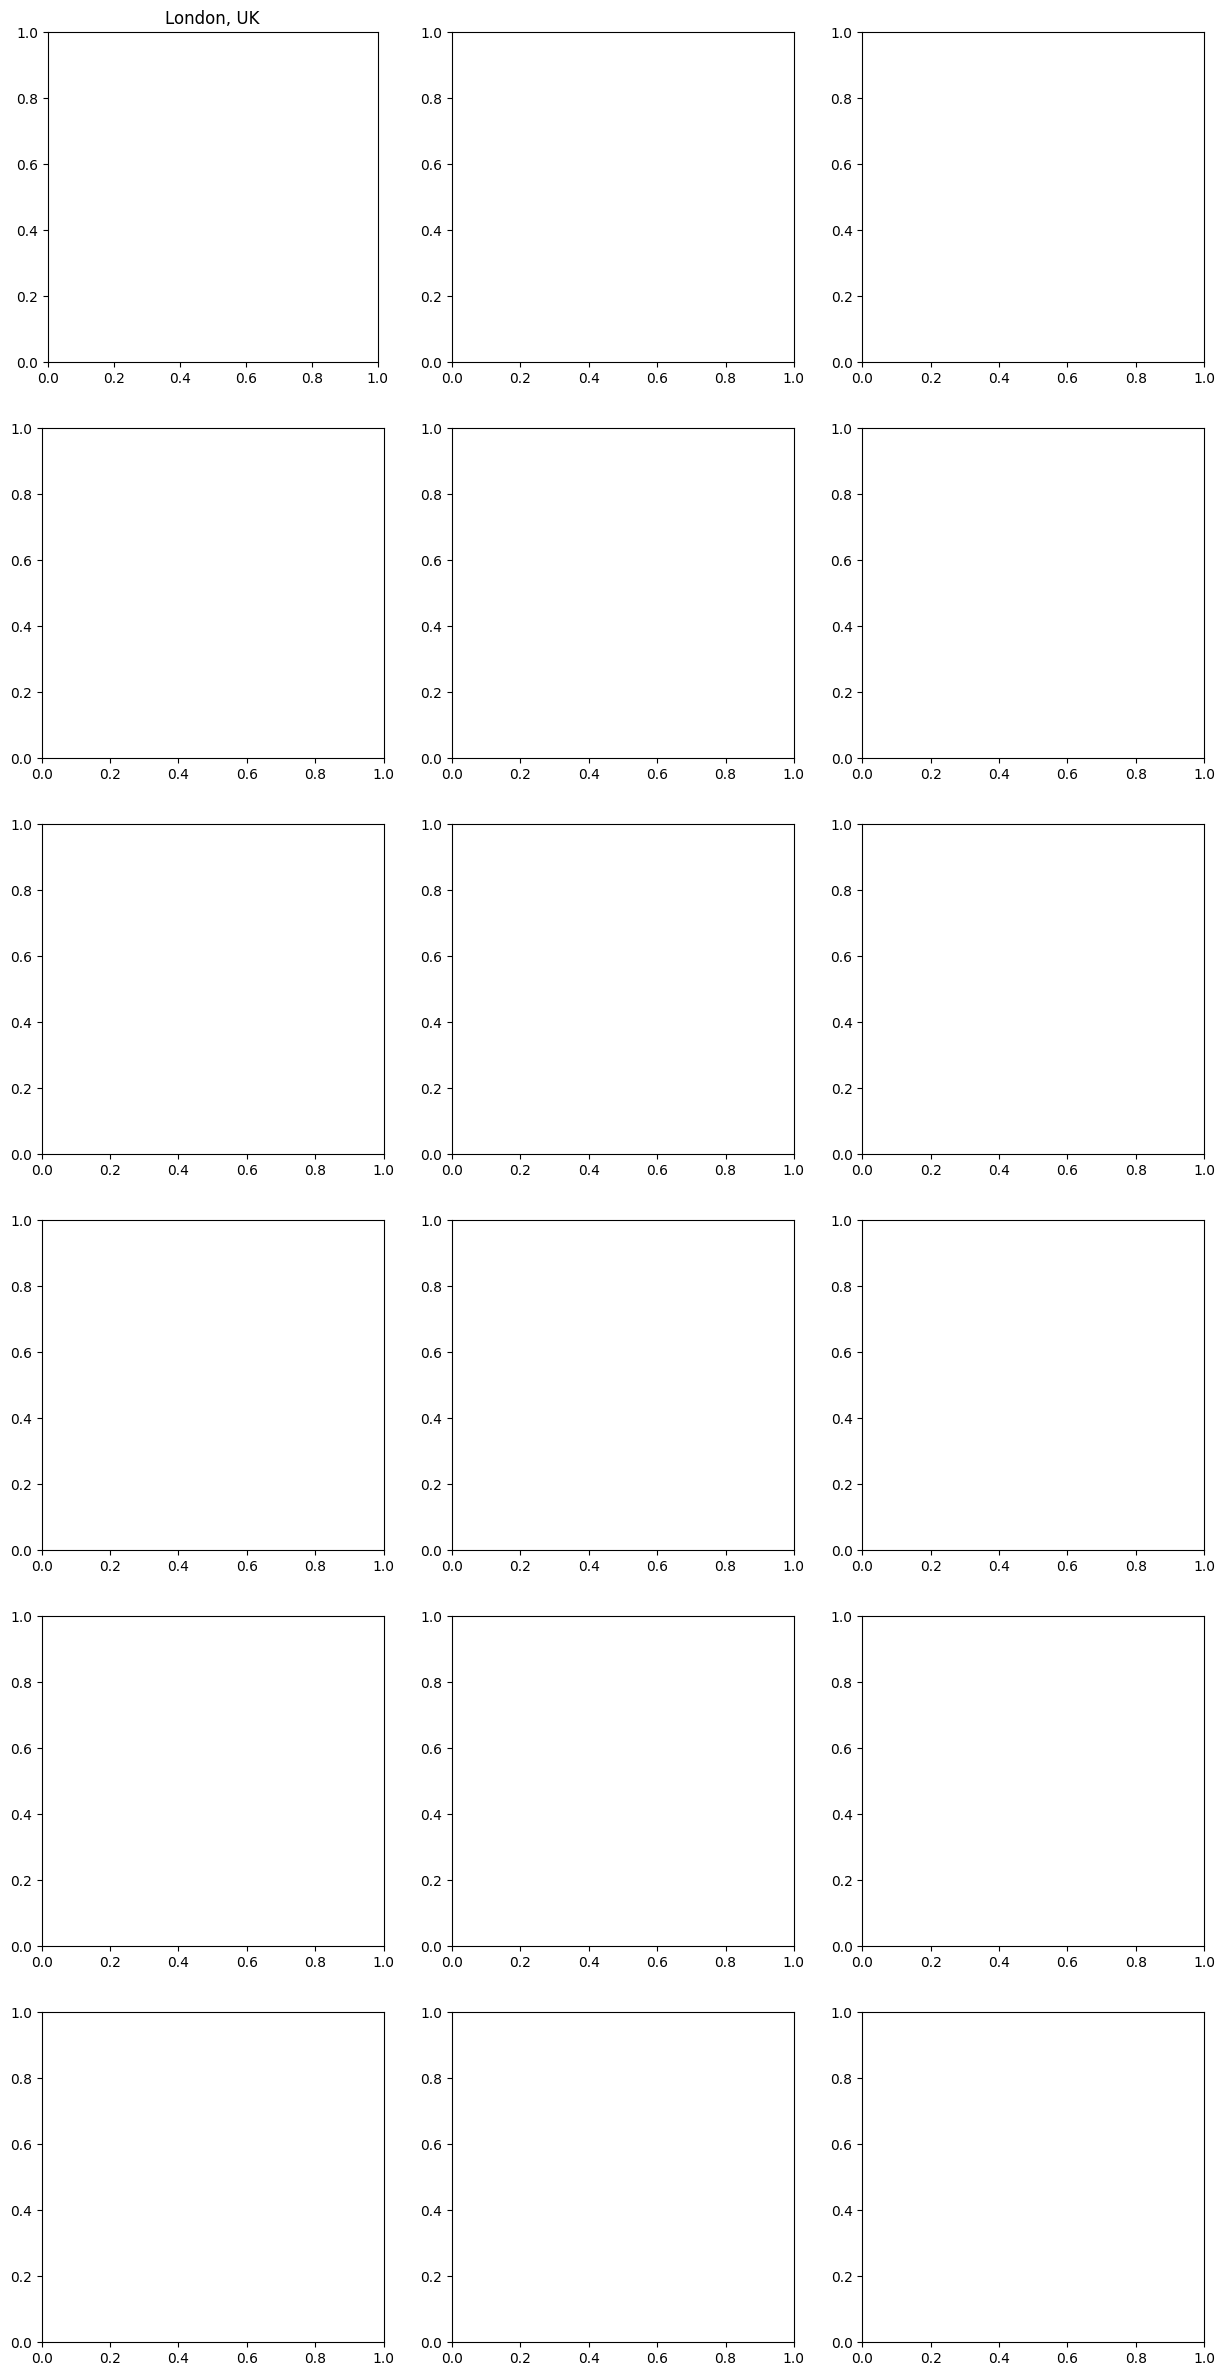

In [11]:
nclusters = 5
cmap = create_cmap(nclusters)

summary_holder = {}


cities = [
    "Boston, USA",
    "London, UK",
    "Seattle, USA",
    "Brussels, Belgium",
    "Seattle, USA",
    "London, UK",
]
pred_cities = [
    "London, UK",
    "Boston, USA",
    "Brussels, Belgium",
    "Seattle, USA",
    "London, UK",
    "Seattle, USA",
]

fig_size = (15, 5 * len(pred_cities))
fig, axs = plt.subplots(
    figsize=fig_size,
    nrows=len(pred_cities),
    ncols=3,
)

for i, (city, pred_city) in enumerate(zip(cities, pred_cities)):
    print(
        f"========================================Studying {city}========================================"
    )

    model = AgglomerativeClustering(
        n_clusters=nclusters, metric="euclidean", linkage="ward"
    )
    del_h3_df = get_del_df(pred_city)
    del_h3_df.rename(columns={"region_id": "h3"}, inplace=True)
    # Specify the feature and target columns
    feature_cols = list(map(str, range(50)))
    model = model.fit(del_h3_df[feature_cols].to_numpy())

    predictions = pd.DataFrame.from_dict(predictions_dict[city + "_To_" + pred_city])
    predictions.columns = [
        "h3",
        "service_time",
        "point prediction",
        "lower",
        "upper",
        "rej_sam_point_pred",
    ]
    predictions.set_index("h3", inplace=True)
    predictions[f"clusters_{pred_city}"] = model.labels_
    del_h3_df[f"clusters_{pred_city}"] = model.labels_

    remap = (
        predictions.groupby(f"clusters_{pred_city}")
        .agg({"service_time": "mean"})
        .sort_values("service_time")
        .reset_index()[f"clusters_{pred_city}"]
        .to_dict()
    )
    remap = {v: k for k, v in remap.items()}

    del_h3_df[f"clusters_{pred_city}"] = del_h3_df[f"clusters_{pred_city}"].map(remap)
    predictions[f"clusters_{pred_city}"] = predictions[f"clusters_{pred_city}"].map(
        remap
    )

    delivery_level_summary_df = summarize_clusters(
        del_h3_df, "service_time", f"clusters_{pred_city}"
    )
    predictions_summary_df = summarize_clusters(
        predictions, "rej_sam_point_pred", f"clusters_{pred_city}"
    )

    summary_holder[pred_city] = {
        "base": {
            "summary_df": delivery_level_summary_df,
            "labelled_deliveries": del_h3_df,
        },
        "predicted": {
            "summary_df": predictions_summary_df,
            "labelled_deliveries": predictions,
        },
    }

    ax = axs[i][0]
    ax.set_title(pred_city)
    create_contextily_plt(
        predictions,
        ax=ax,
        cmap=cmap,
        cluster_col=f"clusters_{pred_city}",
    )
    # turn the legend off
    ax.get_legend().remove()
    ax.set_axis_off()

    ax = axs[i][1]
    create_dist_plt(
        summary_holder[pred_city]["base"]["labelled_deliveries"],
        "service_time",
        ax,
        cmap,
        cluster_col=f"clusters_{pred_city}",
        summary_df=summary_holder[pred_city]["base"]["summary_df"],
    )
    ax.set_title("Base")
    #     set the xlim to be the same for all plots
    ax.set_xlim(0, 600)

    ax = axs[i][2]
    create_dist_plt(
        summary_holder[pred_city]["predicted"]["labelled_deliveries"],
        "service_time",
        ax,
        cmap,
        cluster_col=f"clusters_{pred_city}",
        summary_df=summary_holder[pred_city]["predicted"]["summary_df"],
    )
    ax.set_title(f"Predicted from: {city}")
    ax.set_xlim(0, 600)


fig.savefig(
    f"{os.environ['HOME']}/CQR_Experiments/Figures/all_across_cities_cluster_base_pred_service_times.pdf",
    bbox_inches="tight",
    dpi=100,
)

In [14]:
pd.DataFrame.from_dict(predictions_dict["London, UK" + "_To_" + "London, UK"])

,h3,service_time,median_service_time,lower_quan_service_time,upper_quan_service_time,rej_sample_service_time
0,89195da694fffff,86.0,414.129539,79.692335,172.269885,160.603499
1,89195da694bffff,82.0,479.226882,92.282251,197.924559,192.214348
2,89195da6b97ffff,88.0,478.660195,91.160441,197.544345,96.561043
3,89195da6ad7ffff,107.0,380.728508,74.136996,159.950469,130.447828
4,89195da6ac3ffff,25.0,386.481482,74.549277,160.189971,101.513626
...,...,...,...,...,...,...
13004,89194ad324bffff,181.0,530.253155,102.047602,220.738726,158.267756
13005,89194ad145bffff,212.0,511.962141,99.394742,212.886113,153.202830
13006,89195da6d23ffff,477.0,411.999969,79.816206,171.046731,88.187207
13007,89195da6dcbffff,416.0,416.410249,79.210273,171.658356,101.466557


## Violin Plots


/tmp/ipykernel_3005862/2500515327.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', n_clusters)


========================================Boston, USA========================================
========================================London, UK========================================
========================================Seattle, USA========================================
========================================Brussels, Belgium========================================
========================================Seattle, USA========================================
========================================London, UK========================================


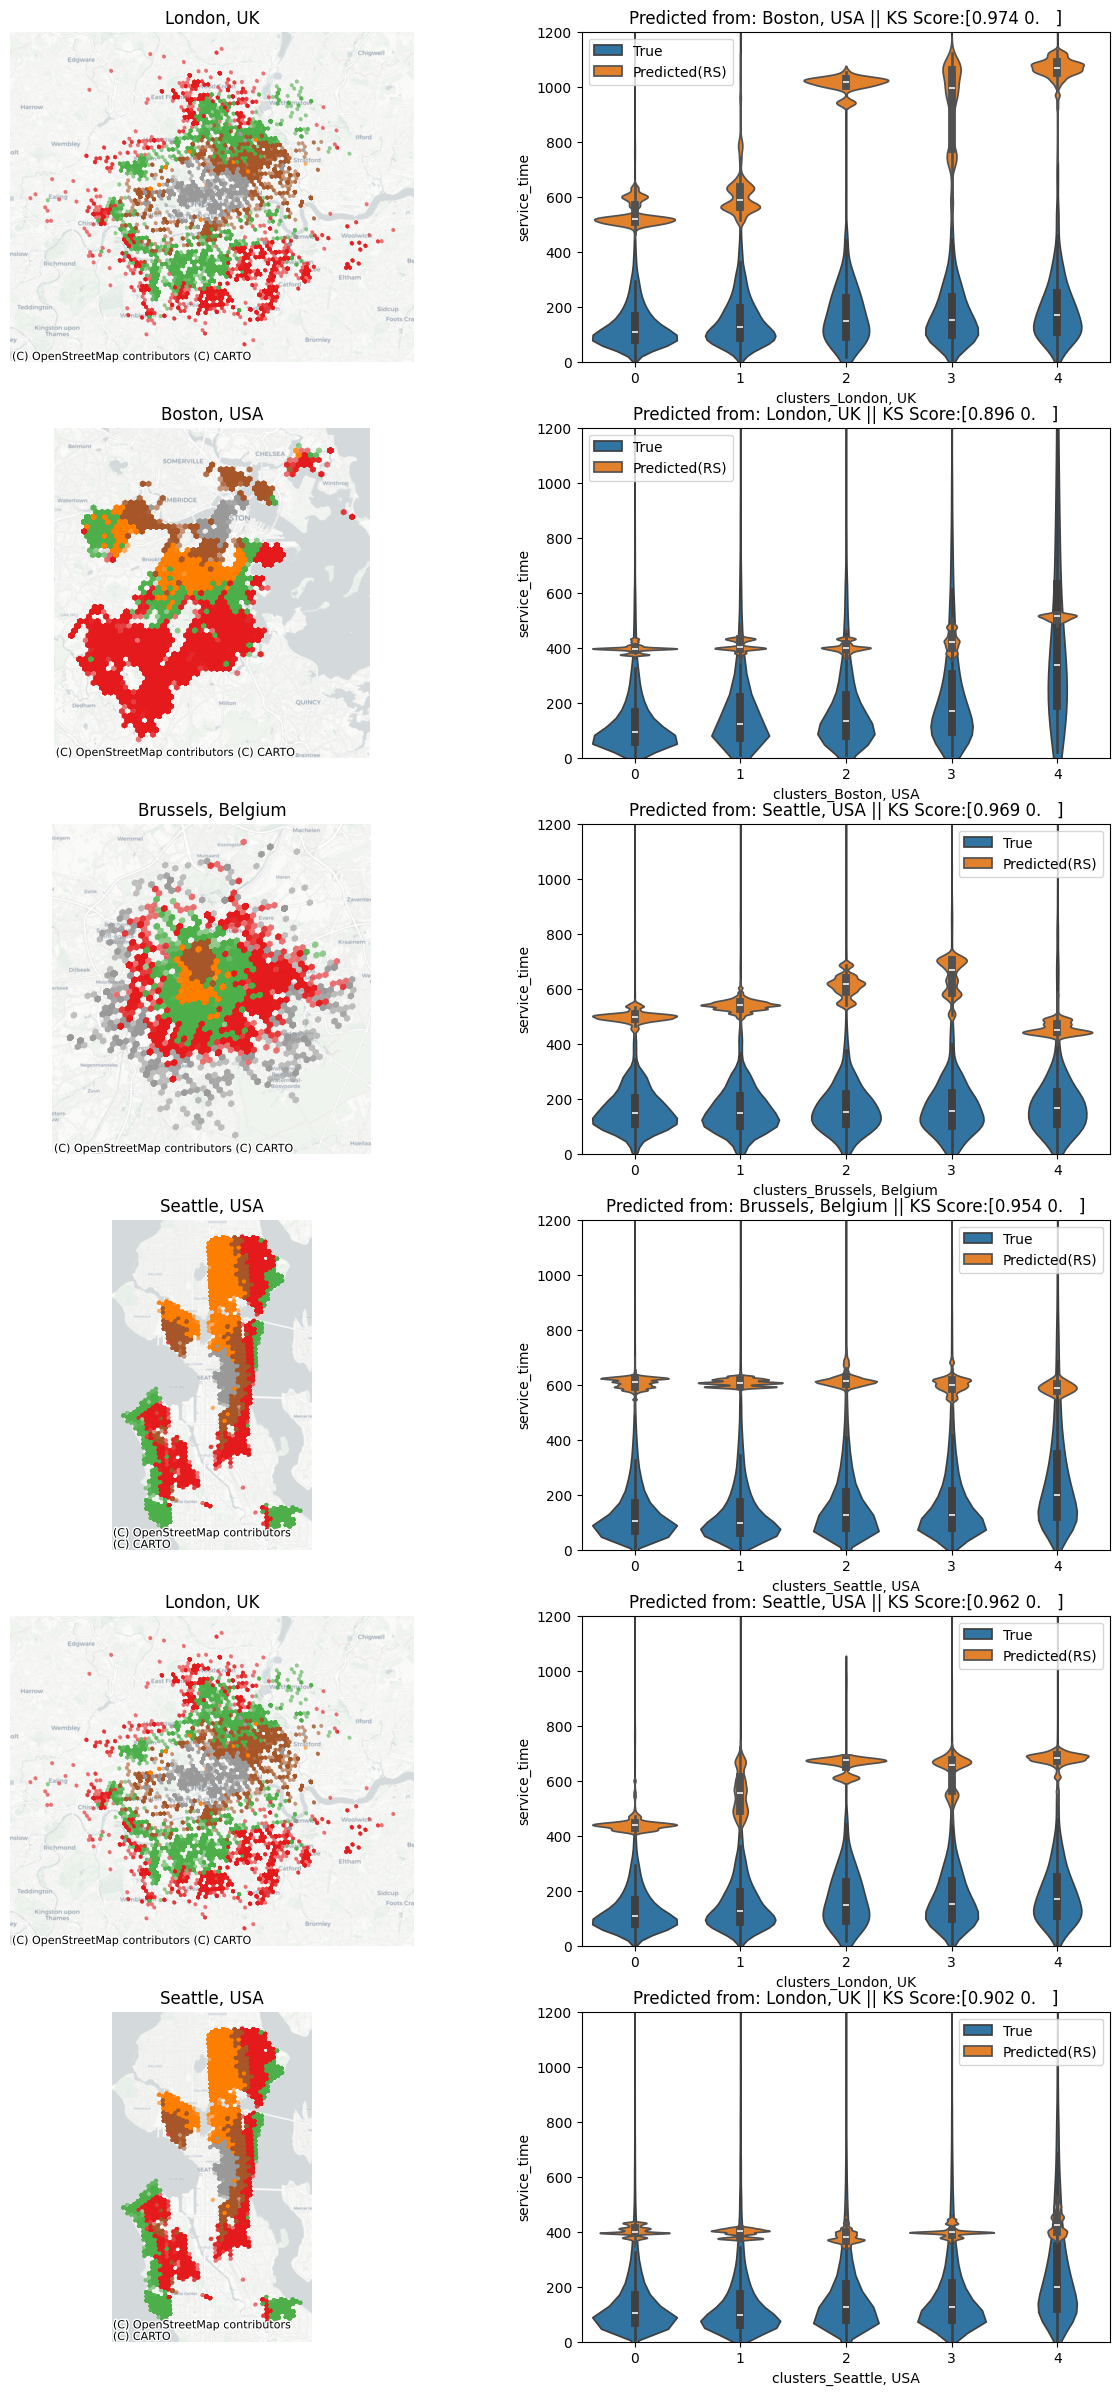

In [8]:
nclusters = 5
cmap = create_cmap(nclusters)

summary_holder = {}


cities = [
    "Boston, USA",
    "London, UK",
    "Seattle, USA",
    "Brussels, Belgium",
    "Seattle, USA",
    "London, UK",
]
pred_cities = [
    "London, UK",
    "Boston, USA",
    "Brussels, Belgium",
    "Seattle, USA",
    "London, UK",
    "Seattle, USA",
]


fig_size = (15, 5 * len(pred_cities))
fig, axs = plt.subplots(
    figsize=fig_size,
    nrows=len(pred_cities),
    ncols=2,
)
for i, (city, pred_city) in enumerate(zip(cities, pred_cities)):
    print(
        f"========================================{city}========================================"
    )

    model = AgglomerativeClustering(
        n_clusters=nclusters, metric="euclidean", linkage="ward"
    )
    del_h3_df = get_del_df(pred_city)
    del_h3_df.rename(columns={"region_id": "h3"}, inplace=True)
    # Specify the feature and target columns
    feature_cols = list(map(str, range(50)))
    model = model.fit(del_h3_df[feature_cols].to_numpy())

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%This block needs to be changes%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    predictions = pd.DataFrame.from_dict(predictions_dict[city + "_To_" + pred_city])
    predictions.columns = [
        "h3",
        "service_time",
        "point prediction",
        "lower",
        "upper",
        "rej_sam_point_pred",
    ]
    predictions.set_index("h3", inplace=True)
    predictions[f"clusters_{pred_city}"] = model.labels_
    del_h3_df[f"clusters_{pred_city}"] = model.labels_

    remap = (
        predictions.groupby(f"clusters_{pred_city}")
        .agg({"service_time": "mean"})
        .sort_values("service_time")
        .reset_index()[f"clusters_{pred_city}"]
        .to_dict()
    )
    remap = {v: k for k, v in remap.items()}

    del_h3_df[f"clusters_{pred_city}"] = del_h3_df[f"clusters_{pred_city}"].map(remap)
    predictions[f"clusters_{pred_city}"] = predictions[f"clusters_{pred_city}"].map(
        remap
    )

    delivery_level_summary_df = summarize_clusters(
        del_h3_df, "service_time", f"clusters_{pred_city}"
    )
    predictions_summary_df = summarize_clusters(
        predictions, "rej_sam_point_pred", f"clusters_{pred_city}"
    )

    summary_holder[pred_city] = {
        "base": {
            "summary_df": delivery_level_summary_df,
            "labelled_deliveries": del_h3_df,
        },
        "predicted": {
            "summary_df": predictions_summary_df,
            "labelled_deliveries": predictions,
        },
    }

    ax = axs[i][0]
    ax.set_title(pred_city)
    create_contextily_plt(
        predictions,
        ax=ax,
        cmap=cmap,
        cluster_col=f"clusters_{pred_city}",
    )
    # turn the legend off
    ax.get_legend().remove()
    ax.set_axis_off()

    ax = axs[i][1]
    sns.violinplot(
        data=predictions,
        x=f"clusters_{pred_city}",
        y="service_time",
        ax=ax,
        label="True",
    )
    sns.violinplot(
        data=predictions,
        x=f"clusters_{pred_city}",
        y="point prediction",
        ax=ax,
        label="Predicted(RS)",
    )
    ax.set_title(
        f"Predicted from: {city} || KS Score:{np.round(stats.ks_2samp(predictions['service_time'], predictions['point prediction']), 3)}"
    )
    ax.set_ylim(0, 1200)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

fig.savefig(
    f"{os.environ['HOME']}/CQR_Experiments/Figures/VIOLIN_all_across_cities_cluster_base_pred_service_times.pdf",
    bbox_inches="tight",
    dpi=100,
)